# Read the images into the program and display them

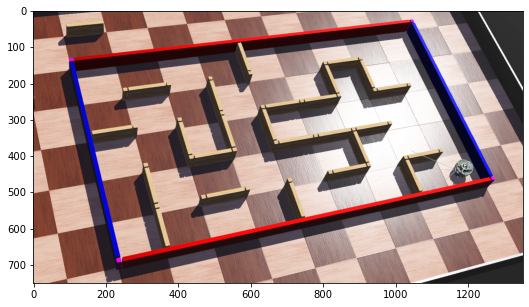

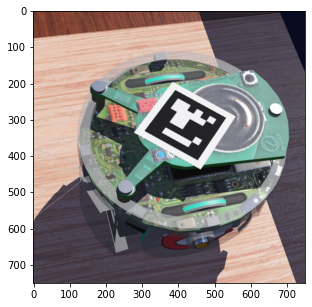

In [7]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import math

%matplotlib inline

MAZE_FILE_NAME = "C:/Users/g2754/Documents/A/20T2/4110/PhaseC/MTRN4110_20T2_Python/Maze_2.png"
ROBOT_FILE_NAME = "C:/Users/g2754/Documents/A/20T2/4110/PhaseC/MTRN4110_20T2_Python/Robot_2.png"
MAP_FILE_NAME = "C:/Users/g2754/Documents/A/20T2/4110/PhaseC/MTRN4110_20T2_Python/MapFound_2.txt"

img1 = cv2.imread(MAZE_FILE_NAME)
img1_rgb = cv2.cvtColor(img1, cv2.COLOR_BGR2RGB)
plt.figure(figsize = (9, 5))
plt.imshow(img1_rgb)

img2 = cv2.imread(ROBOT_FILE_NAME)
img2_rgb = cv2.cvtColor(img2, cv2.COLOR_BGR2RGB)
plt.figure(figsize = (9, 5))
plt.imshow(img2_rgb)

# Find the four cornerstones of the maze 

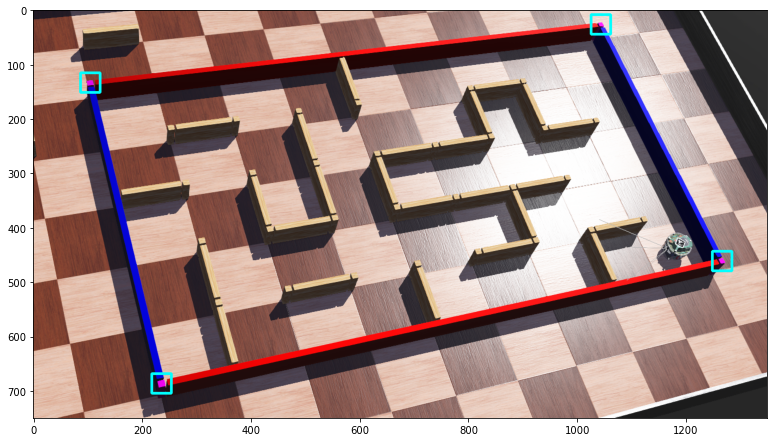

In [8]:
hmin = 135
smin = 148
vmin = 108
hmax = 162
smax = 255
vmax = 255
lower = np.array([hmin, smin, vmin])
upper = np.array([hmax, smax, vmax])

img3 = cv2.cvtColor(img1, cv2.COLOR_BGR2HSV)
mask = cv2.inRange(img3, lower, upper)
img3 = cv2.cvtColor(img3, cv2.COLOR_HSV2RGB)

mask_3_channel = cv2.cvtColor(mask, cv2.COLOR_GRAY2BGR)

edges = cv2.Canny(mask_3_channel, threshold1 = 500, threshold2 = 1200, apertureSize = 5)
img4, contours, hierarchy = cv2.findContours(edges, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

list_centroidX = []
list_centroidY = []
for i, cnt in enumerate(contours):
    m = cv2.moments(cnt)
    area = cv2.contourArea(cnt)
    if area > 40:
        u = m['m10']/m['m00']
        v = m['m01']/m['m00']
        list_centroidX.append(u)
        list_centroidY.append(v)
        u = round(u)
        v = round(v)
        cv2.rectangle(img3,(u-18,v-18),(u+18,v+18),(0,255,255),3)

plt.figure(figsize = (13.5, 7.5))
plt.imshow(img3)

# Perspective transform the maze from the original image to a rectangle image 

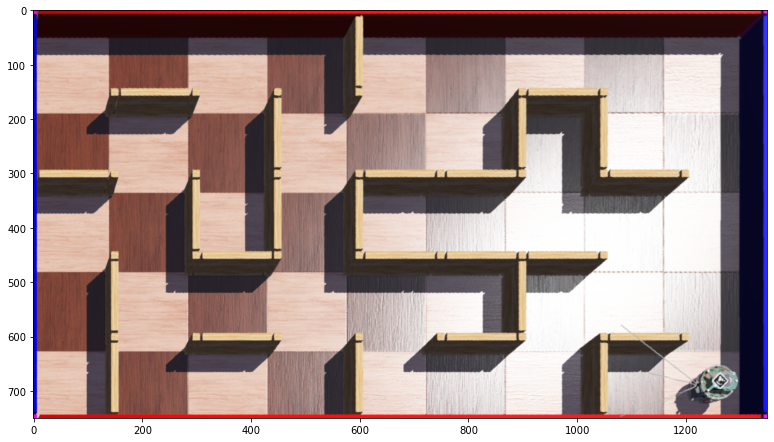

In [9]:
list_orderx = [0, 0, 0, 0]
list_ordery = [0, 0, 0, 0]
for i in range(len(list_centroidX)):
    if list_centroidX[i] < 337.5 :
        if list_centroidY[i] < 375 :
            list_orderx[0] = list_centroidX[i]
            list_ordery[0] = list_centroidY[i]
        else:
            list_orderx[2] = list_centroidX[i]
            list_ordery[2] = list_centroidY[i]
    else:
        if list_centroidY[i] < 375 :
            list_orderx[1] = list_centroidX[i]
            list_ordery[1] = list_centroidY[i]
        else:
            list_orderx[3] = list_centroidX[i]
            list_ordery[3] = list_centroidY[i]
    
pts1 = np.float32([[list_orderx[0],list_ordery[0]],[list_orderx[1],list_ordery[1]],[list_orderx[2],list_ordery[2]],[list_orderx[3],list_ordery[3]]])
pts2 = np.float32([[0,0],[1350,0],[0,750],[1350,750]]) # four points on the second image

H = cv2.getPerspectiveTransform(pts1, pts2) # homography matrix
#print(H)

dst = cv2.warpPerspective(img1_rgb, H, (1350,750))
dst1 = cv2.warpPerspective(img1_rgb, H, (1350,750))

plt.figure(figsize = (13.5, 7.5))
plt.imshow(dst)

# Detect all the internal walls 

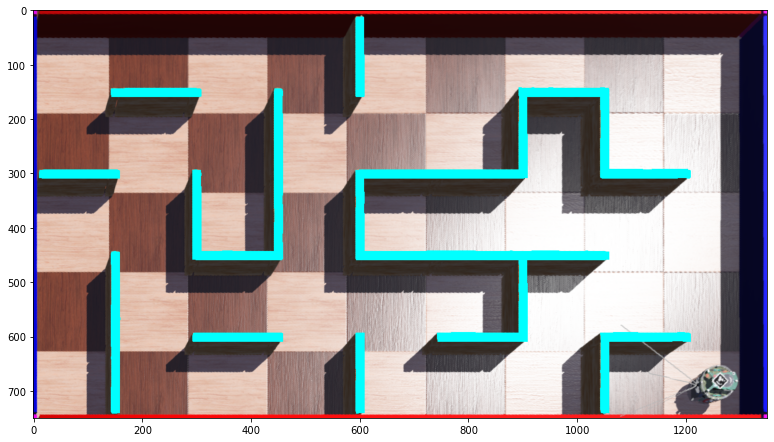

In [10]:
hmin = 18
smin = 50
vmin = 225
hmax = 25
smax = 255
vmax = 255
lower = np.array([hmin, smin, vmin])
upper = np.array([hmax, smax, vmax])

img5 = cv2.cvtColor(dst, cv2.COLOR_RGB2HSV)
mask = cv2.inRange(img5, lower, upper)
mask_3_channel = cv2.cvtColor(mask, cv2.COLOR_GRAY2BGR)
kernel = np.ones((20,20),np.uint8)
closing = cv2.morphologyEx(mask_3_channel, cv2.MORPH_CLOSE, kernel)

kernel = np.ones((3,3),np.uint8)
dilation = cv2.dilate(closing,kernel,iterations = 2)

indices = np.where(dilation==255)
dst[indices[0], indices[1], :] = [0,255,255]
plt.figure(figsize = (13.5, 7.5))
plt.imshow(dst)

# Detect the location and heading of the robot

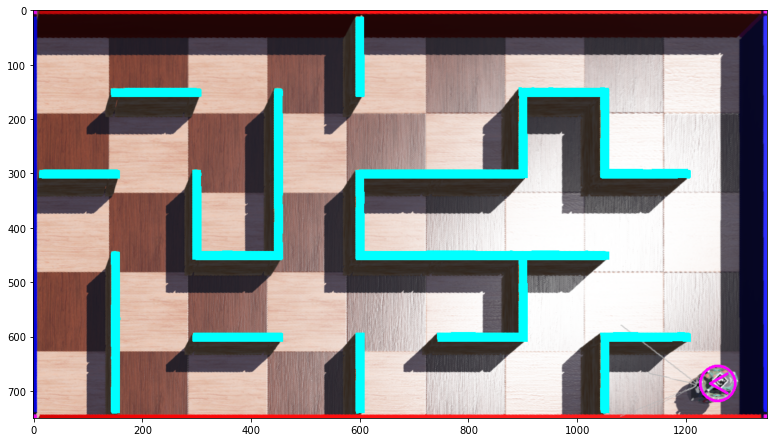

In [11]:
hmin = 40
smin = 0
vmin = 0
hmax = 100
smax = 255
vmax = 255
lower = np.array([hmin, smin, vmin])
upper = np.array([hmax, smax, vmax])

img6 = cv2.cvtColor(dst1, cv2.COLOR_RGB2HSV)
mask = cv2.inRange(img6, lower, upper)
mask_3_channel = cv2.cvtColor(mask, cv2.COLOR_GRAY2BGR)

kernel = np.ones((15,15),np.uint8)
closing = cv2.morphologyEx(mask_3_channel, cv2.MORPH_CLOSE, kernel)
edges = cv2.Canny(closing, threshold1 = 500, threshold2 = 1500, apertureSize = 5)
img7, contours, hierarchy = cv2.findContours(edges, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

for i, cnt in enumerate(contours):
    m = cv2.moments(cnt)
    area = cv2.contourArea(cnt)
    if area > 500:
        u = round(m['m10']/m['m00'])
        v = round(m['m01']/m['m00'])
        dst = cv2.ellipse(dst, (u,v), (32,32), 0, 0, 360,(255,0,255),3) 

aruco = cv2.warpPerspective(img2_rgb, H, (750,750))
dictionary = cv2.aruco.Dictionary_get(cv2.aruco.DICT_6X6_250)
parameters =  cv2.aruco.DetectorParameters_create()
markerCorners, markerIds, rejectedCandidates = cv2.aruco.detectMarkers(aruco, dictionary, parameters=parameters)

if markerCorners[0][0][0][0] < markerCorners[0][0][1][0]:
    if markerCorners[0][0][0][1] < markerCorners[0][0][1][1]:
        message = '^'
    else:
        message = '<'
else:
    if markerCorners[0][0][0][1] < markerCorners[0][0][1][1]:
        message = '>'
    else:
        message = 'v'
        
cv2.putText(dst,message,(u-22,v+18),cv2.FONT_HERSHEY_SIMPLEX,2,(255,0,255),4)

plt.figure(figsize = (13.5, 7.5))
plt.imshow(dst)

# Generate a map and write it to a text file

In [12]:
verticalW = np.zeros((5,36),np.str)
row = 0
col = 0
i = 100
j = 150

while i < 750:
    while j < 1350:
        px_rgb = dilation[i, j-20:j+20]
        if np.any(px_rgb) != 0:
            verticalW[row][col] = ' '
            verticalW[row][col+1] = ' '
            verticalW[row][col+2] = ' '
            verticalW[row][col+3] = '|'
        else:
            verticalW[row][col] = ' '
            verticalW[row][col+1] = ' '
            verticalW[row][col+2] = ' '
            verticalW[row][col+3] = ' '
        j = j + 150
        col += 4
    
    verticalW[row][col] = ' '
    verticalW[row][col+1] = ' '
    verticalW[row][col+2] = ' '
    verticalW[row][col+3] = '|'
    row += 1
    col = 0
    j = 150
    i = i + 150

horizontalW = np.zeros((4,37),np.str)
row = 0
col = 0
i = 150
j = 50


while i < 750:
    while j < 1350:
        px_rgb = dilation[i-20:i+20, j]
        if np.any(px_rgb) != 0:
            horizontalW[row][col] = '-'
            horizontalW[row][col+1] = '-'
            horizontalW[row][col+2] = '-'
            horizontalW[row][col+3] = ' '
        else:
            horizontalW[row][col] = ' '
            horizontalW[row][col+1] = ' '
            horizontalW[row][col+2] = ' '
            horizontalW[row][col+3] = ' '
        j = j + 150
        col += 4
    
    row += 1
    col = 0
    j = 50
    i = i + 150

rowRobot = math.floor(v/150)
colRobot = math.floor(u/150)
verticalW[rowRobot][colRobot*4+1] = message

file = open(MAP_FILE_NAME, "w")

file.write( " --- --- --- --- --- --- --- --- --- \n")

row = 0
i = 0
horizontalCounter = 0
verticalCounter = 0
while row < 9:
    if row % 2 == 0:
        file.write('|')
        while i < 36:
            file.write(verticalW[verticalCounter][i])
            i += 1
        file.write("\n")
        i = 0
        verticalCounter += 1
    else:
        file.write(' ')
        while i < 37:
            file.write(horizontalW[horizontalCounter][i])
            i += 1
        file.write("\n")
        i = 0
        horizontalCounter += 1
        
    row += 1

file.write( " --- --- --- --- --- --- --- --- --- \n")

file.close()